In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import heaviside as H, transpose as T

%config InlineBackend.figure_format = 'retina'

### Spike Response Model

In [2]:
class SRM:
    def __init__(self, sensors_layers_dim, hidden_dims, output_dim=2, nu=1, tau=1, tau_s=1, th=0.25):
        """
        class for SRM model with two hidden layers 
        """
        self.hidden_dim_1, self.hidden_dim_2 = hidden_dims
        self.sensors_layers_dim = sensors_layers_dim
        self.output_dim = output_dim
        
        self.nu = nu # threshold 
        self.tau = tau # time constant
        self.tau_s = tau_s # time constant
        self.th = th # threshold spiking 
        
        # initial transmission delays
        
        self.d1 = np.random.uniform(1, 5, size=(self.sensors_layers_dim, self.hidden_dim_1))
        self.d2 = np.random.uniform(1, 5, size=(self.hidden_dim_1, self.hidden_dim_2))
        self.d3 = np.random.uniform(1, 5, size=(self.hidden_dim_2, self.output_dim))

        # weights 
        self.w1 = np.random.uniform(0, 1, size=(self.sensors_layers_dim, self.hidden_dim_1))
        self.w2 = np.random.uniform(0, 1, size=(self.hidden_dim_1, self.hidden_dim_2))
        self.w3 = np.random.uniform(0, 1, size=(self.hidden_dim_2, self.output_dim))
        

    def eta(self, s):
        # kernel function
        return - self.nu * np.exp(-s / self.tau) * H(s, 0)

    def eps(self, x):
        # the generic response  of neuron Nj to spikes coming from presynaptic neurons Ni
        # d - axonal transmission delay
        return (x) * np.exp(-x) * H(self.tau_s * x, 0)

    def u(self, t, t_hat_j, w, d_ax, t_hat_i):
        # t -- time, last_t -- last spike time, d -- connection delay, w -- weight of connection
        # integrating the equation on a small time window of 1ms and assuming that 
        # each presynaptic neuron fires at most once in the time window
    
        return self.eta(t - t_hat_j) + np.sum(w * self.eps((T(t - t_hat_i - T(d_ax)) - d_ax)/self.tau_s), axis=0)
    
    def init_forward(self, time, spikes):
        self.ttt_input = np.zeros((self.sensors_layers_dim))
        self.ttt_hidden_1, self.ttt_hidden_2  = np.zeros((self.hidden_dim_1)), np.zeros((self.hidden_dim_2))
        self.ttt_output = np.zeros((self.output_dim))
        
        self.u_hidden_1, self.u_hidden_2 = np.zeros((self.hidden_dim_1, time)), np.zeros((self.hidden_dim_2, time))
        self.u_out = np.zeros((self.output_dim, time))
        
        self.spikes_input = spikes
        self.spikes_hidden_1, self.spikes_hidden_2 = np.zeros((self.hidden_dim_1, time)), np.zeros((self.hidden_dim_2, time))
        self.spikes_out = np.zeros((self.output_dim, time)) 
        
    def update(self, t, spikes):
        self.ttt_input = np.maximum(self.ttt_input, t * spikes[:, t])
        self.ttt_hidden_1 = np.maximum(self.ttt_hidden_1, t * self.spikes_hidden_1[:, t])
        self.ttt_hidden_2 = np.maximum(self.ttt_hidden_2, t * self.spikes_hidden_2[:, t])
        self.ttt_output = np.maximum(self.ttt_output, t * self.spikes_out[:, t])

                            
    def forward(self, time, spikes):
        self.init_forward(time, spikes)
        for t in range(time):
            #input - hidden1
            self.u_hidden_1[:, t] = self.u(t, self.ttt_hidden_1, self.w1, self.d1, self.ttt_input)
            self.spikes_hidden_1[:, t] = (self.u_hidden_1[:, t] >= self.th).astype(int)

            #hidden1 - hidden2
            self.u_hidden_2[:, t] = self.u(t, self.ttt_hidden_2, self.w2, self.d2,  self.ttt_hidden_1)
            self.spikes_hidden_2[:, t] = (self.u_hidden_2[:, t] >= self.th).astype(int)
            #hidden2 - output
            self.u_out[:, t] = self.u(t, self.ttt_output,  self.w3, self.d3, self.ttt_hidden_2)
            self.spikes_out[:, t] = (self.u_out[:, t] >= self.th).astype(int)
            
            self.update(t, spikes)
            
def spike_pattern(sensors_layers_dim, t_experimnet, par=1):
    """
    Generate spikes
    """
    spikes = np.zeros((sensors_layers_dim, t_experimnet))
    for layer in range(sensors_layers_dim):
        t = 0
        spikes_t = np.zeros(t_experimnet)
        while (t < t_experimnet):
            t += np.random.poisson(par)
            if t >= t_experimnet:
                break
            spikes_t[t] = 1
        spikes[layer] = spikes_t
    return spikes
    
def plot_spikes(SRM):
    """
    Plot spikes on each layer
    """
    layers = [SRM.spikes_input, SRM.spikes_hidden_1, SRM.spikes_hidden_2, SRM.spikes_out]
    layers_names = ['Input layer', 'Hidden layer 1', 'Hidden layer 2', 'Output layer',]
    for layer, name in zip(layers, layers_names):
        plot_layer_spikes(layer, name)

def plot_layer_spikes(layer_spikes, layer_name):
    """
    Plot spikes on the layer
    """
    fig = plt.figure(figsize=(30, 5))
    plt.suptitle(layer_name, fontsize=16)

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(layer_spikes.mean(axis=0))
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('Share of active neurons', fontsize=16)
    ax1.set_title('Share of active neurons on each timestamp')

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(layer_spikes[np.argmax(np.sum(layer_spikes, axis=1))], color='g')
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('Spikes', fontsize=16)
    ax2.set_title('Spiking of the most active neuron')

def run_experiment(time=250, sensors_level_size=5, hidden_dim_1=10, hidden_dim_2=20):
    """
    Run experiment with one pattern 
    """
    pattern = spike_pattern(sensors_level_size, time)
    SRM_ex = SRM(sensors_level_size, (hidden_dim_1, hidden_dim_2))
    SRM_ex.forward(time, pattern)
    plot_spikes(SRM_ex)

### Patten 1

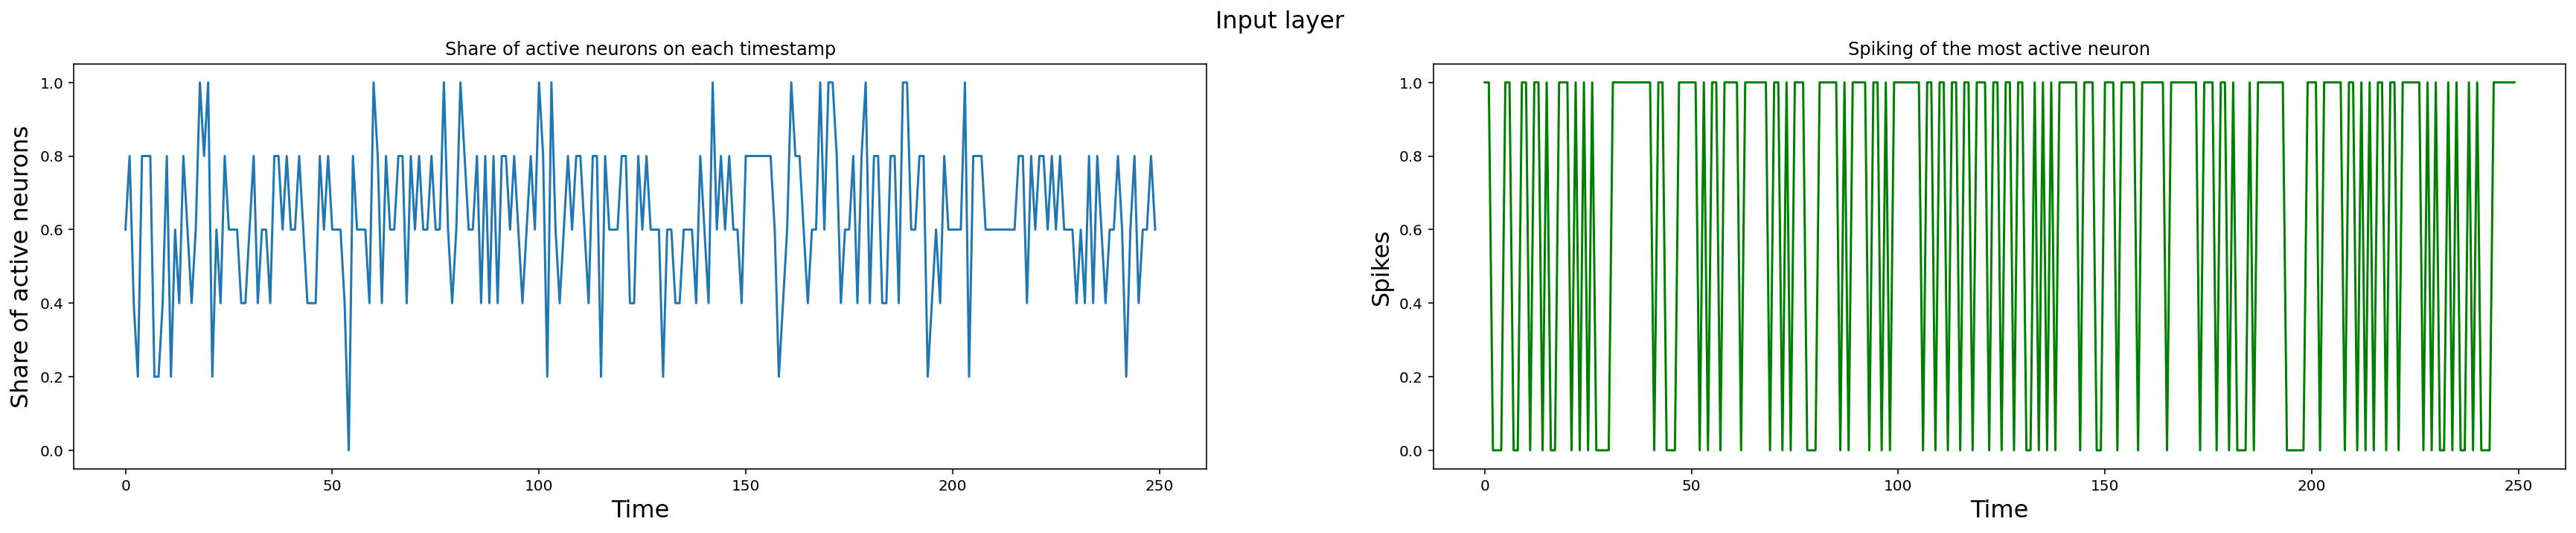

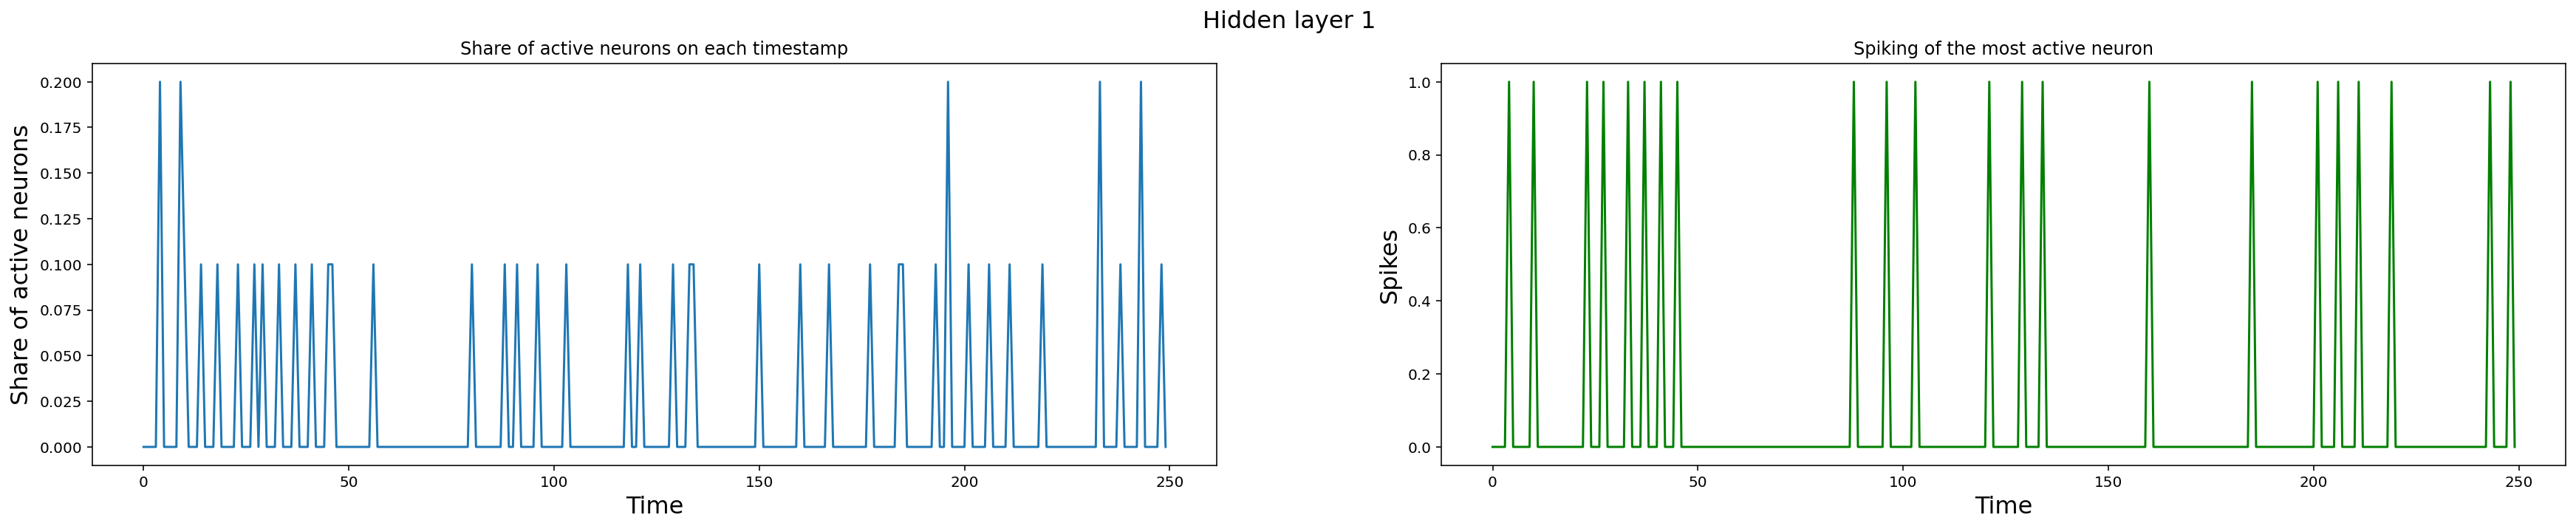

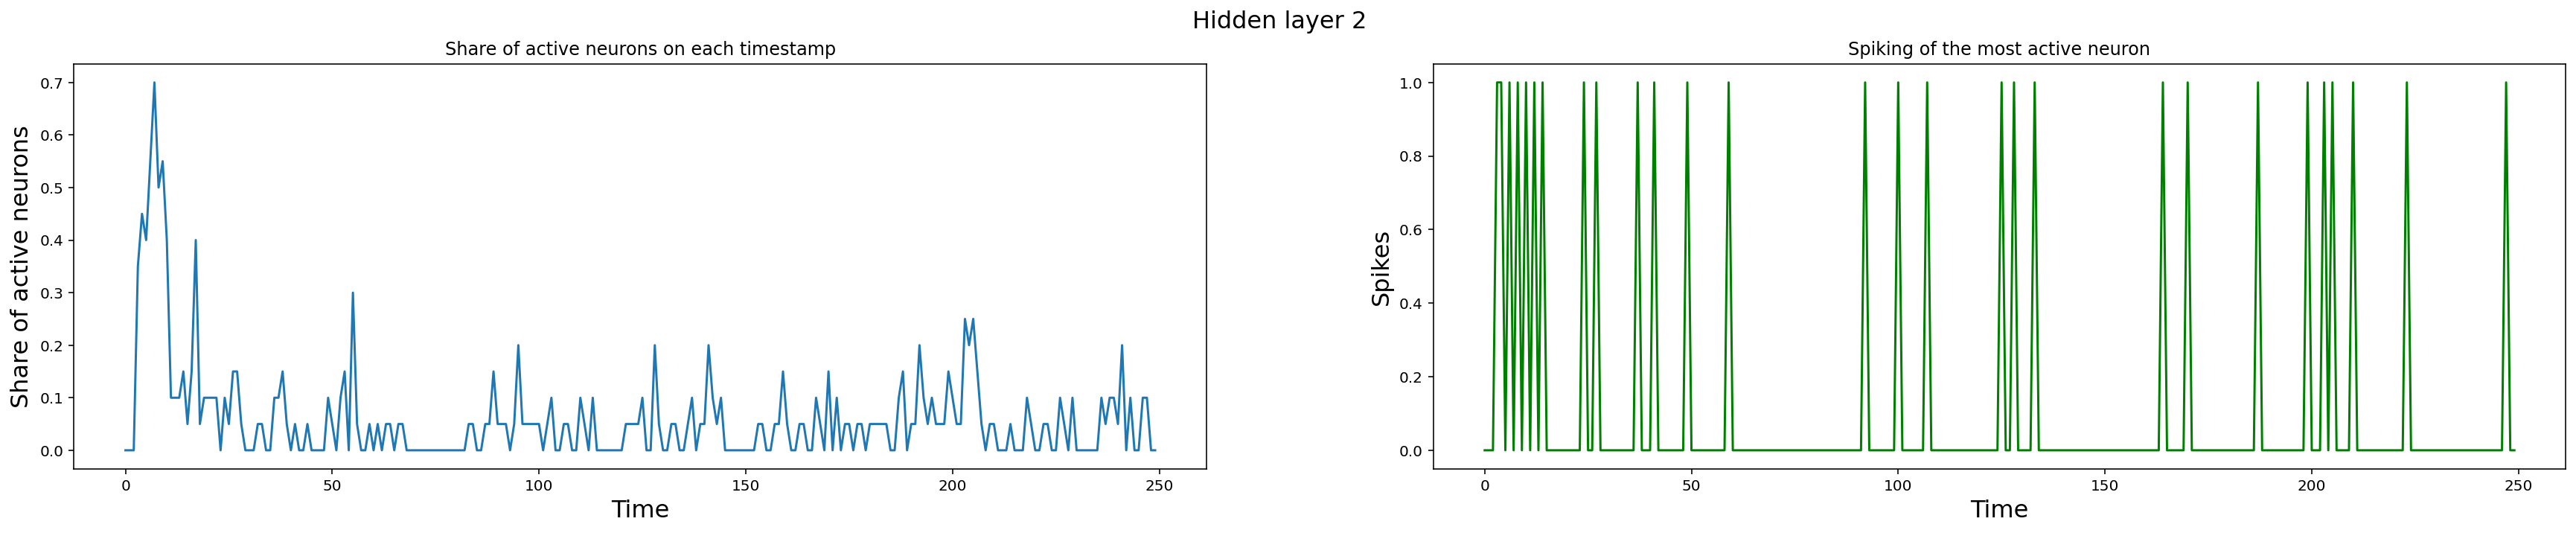

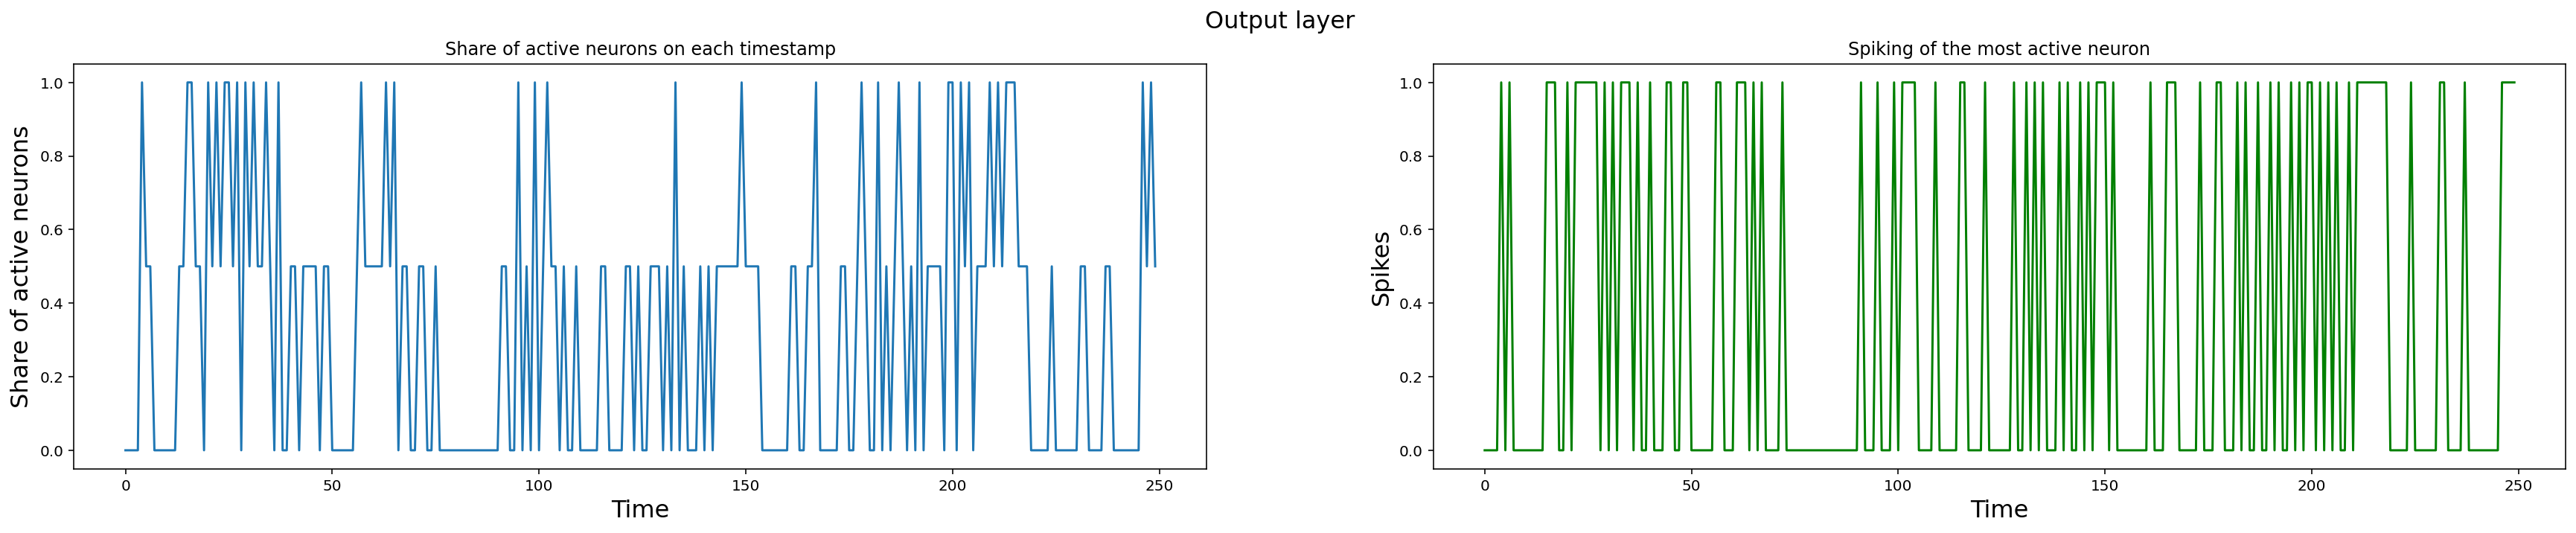

In [3]:
run_experiment()

### Patten 2

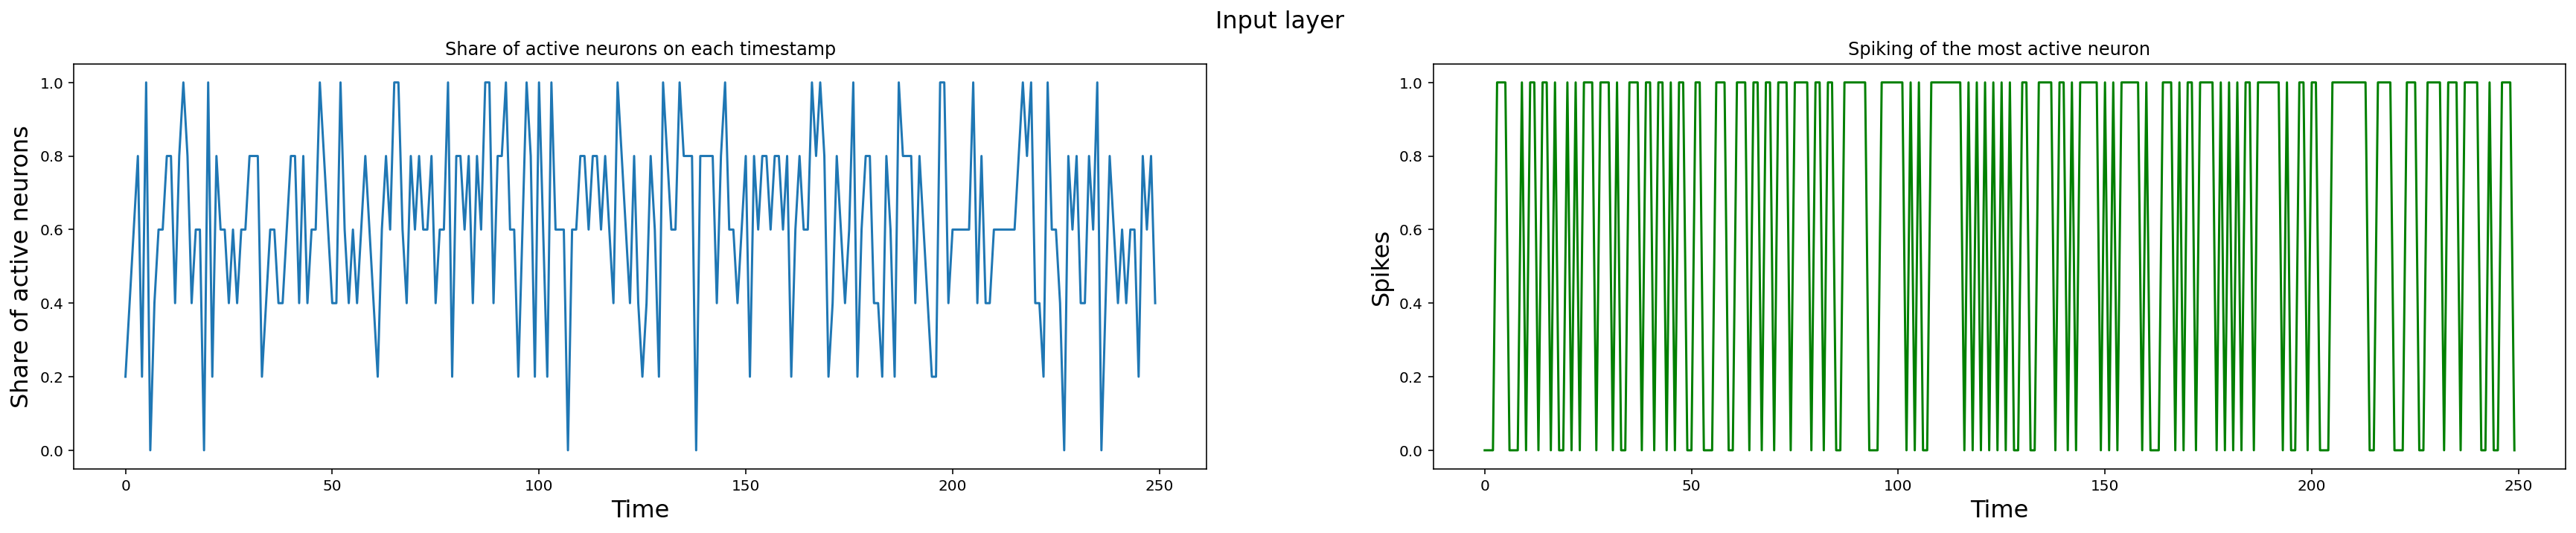

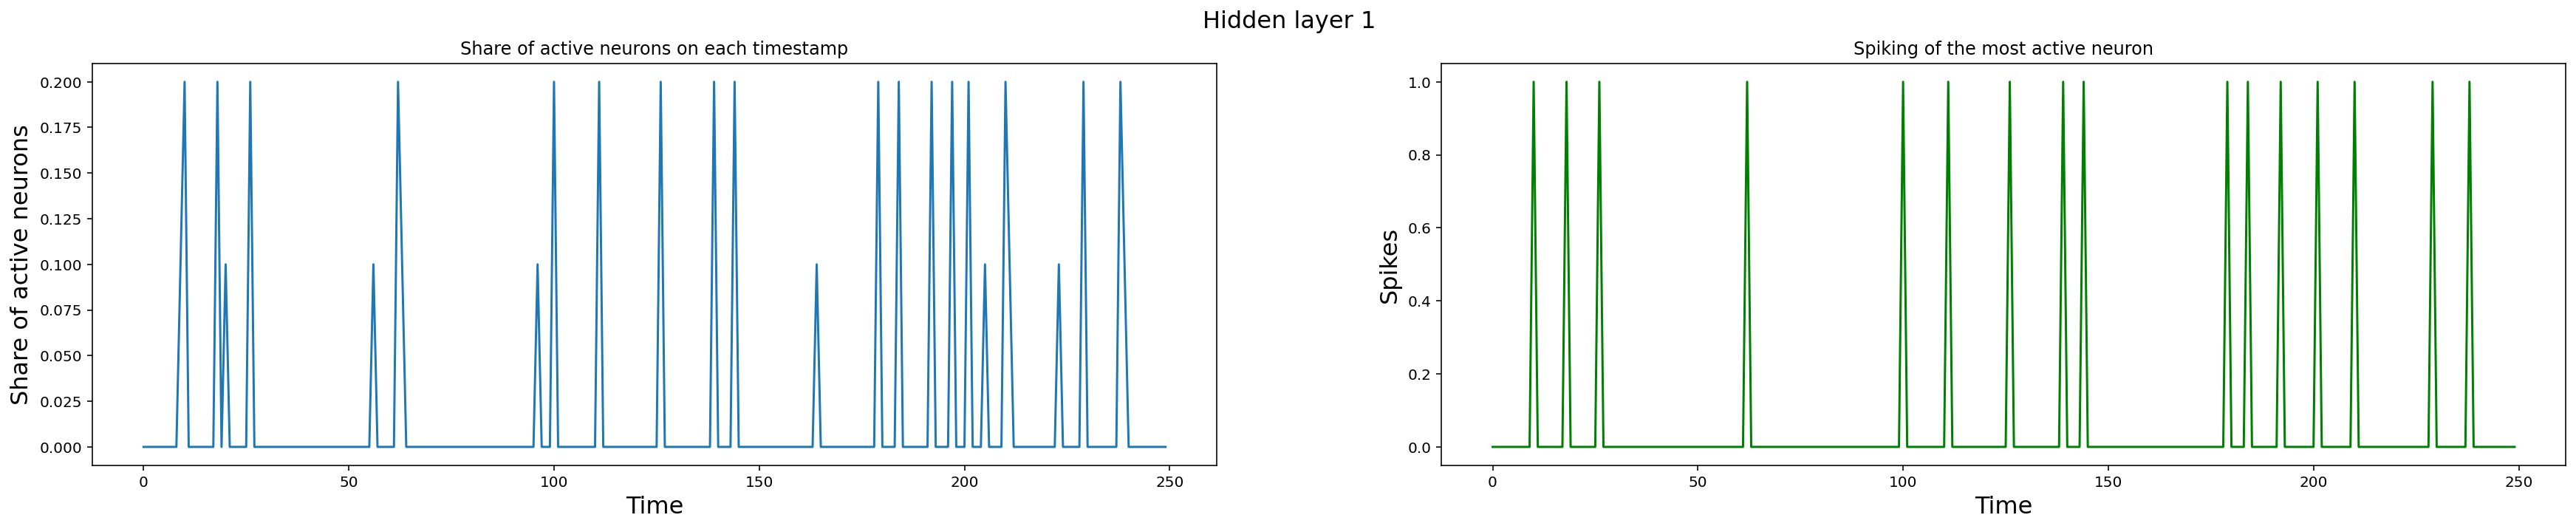

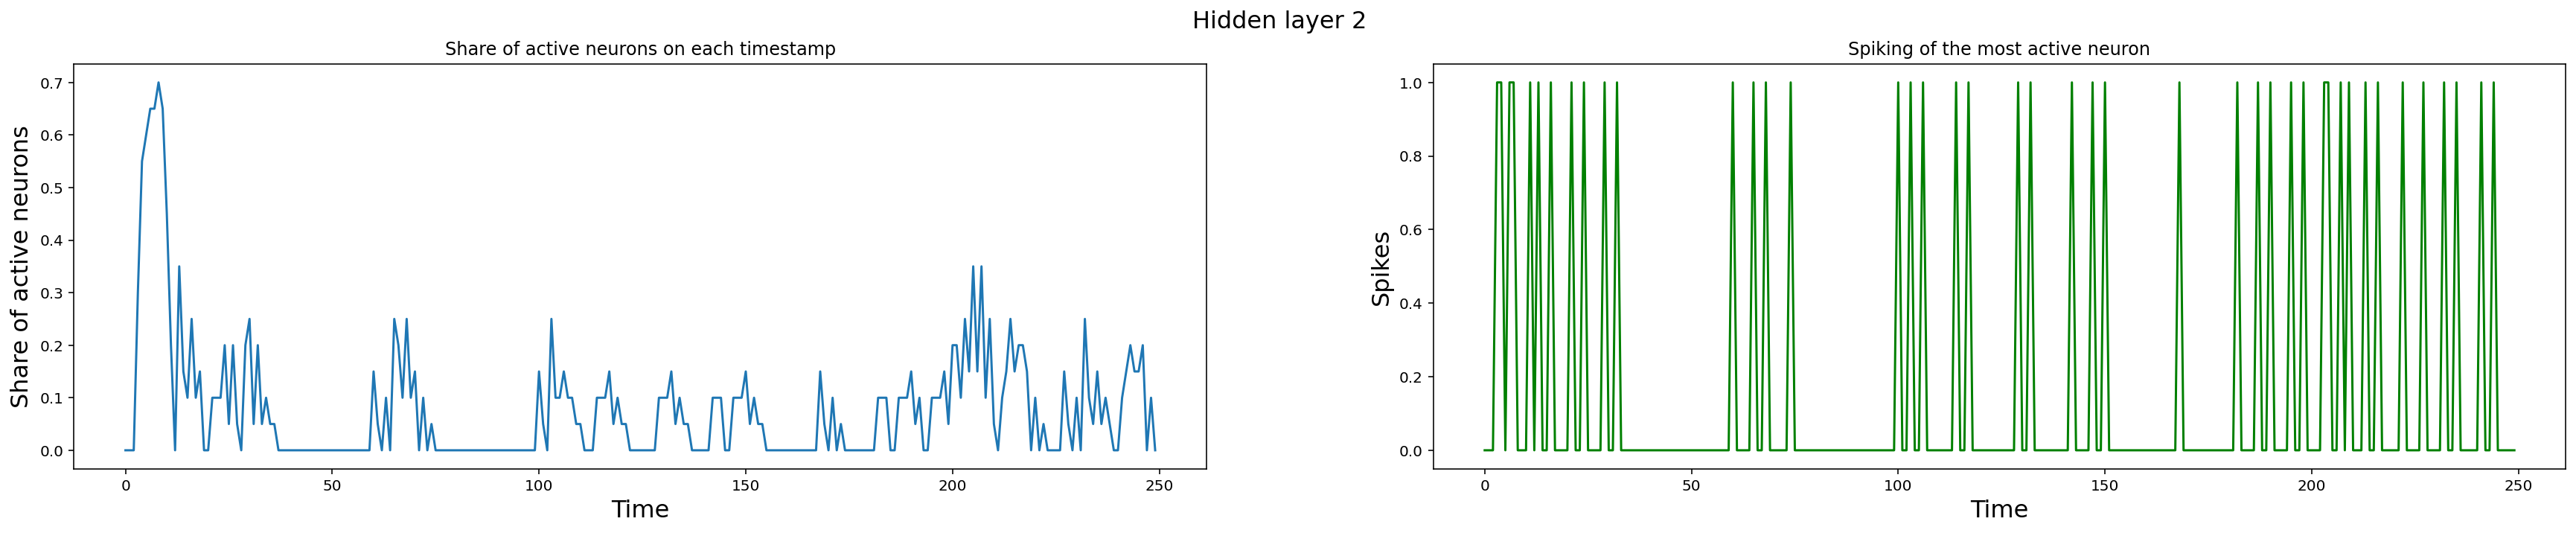

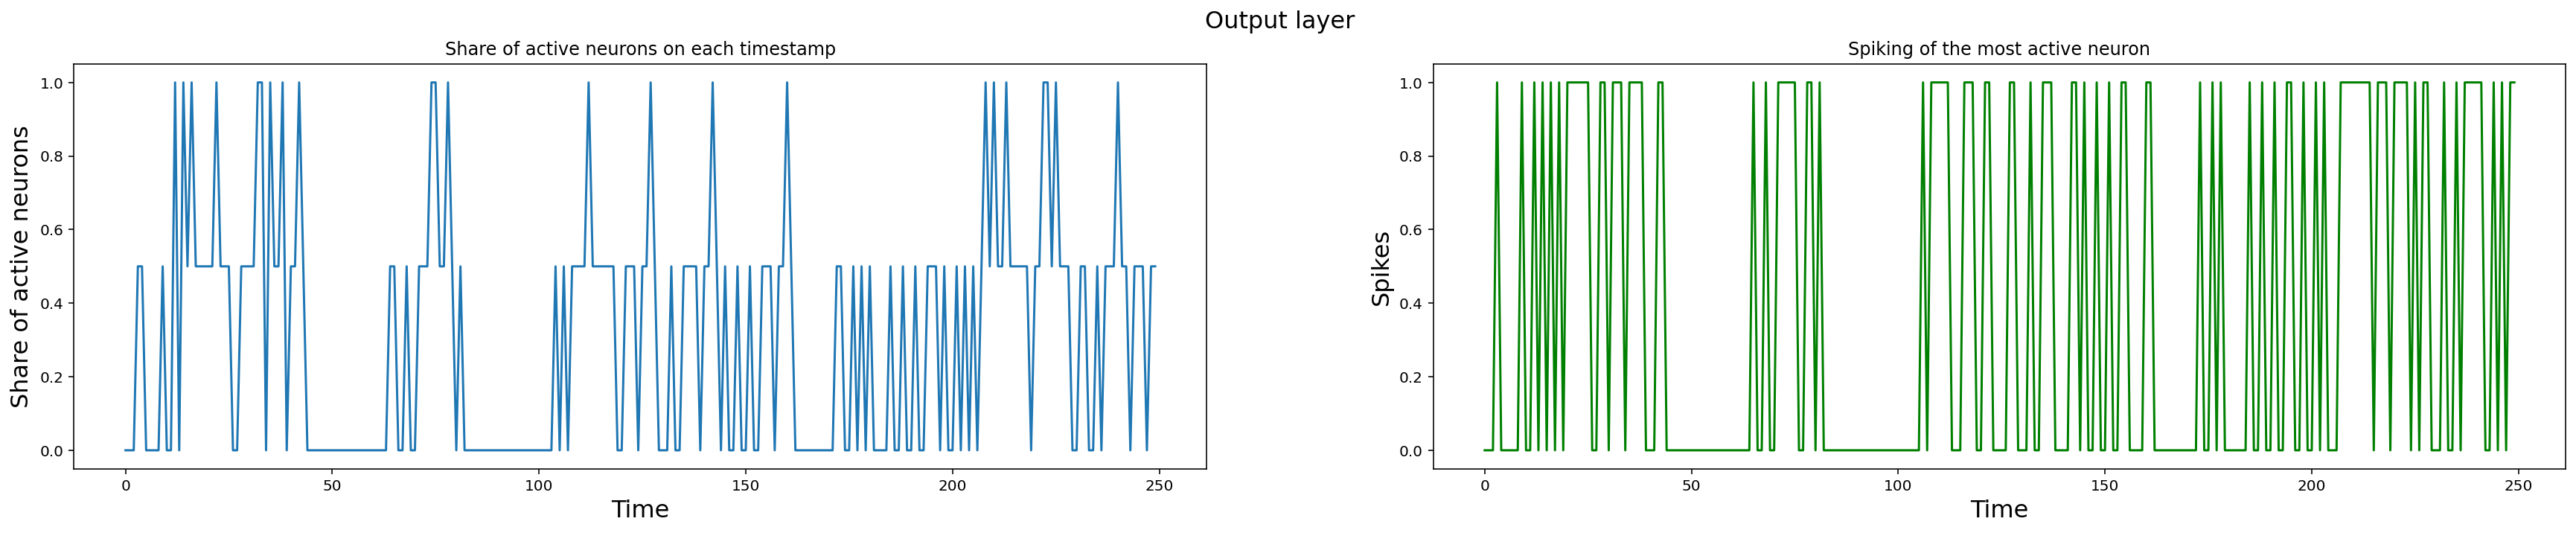

In [4]:
run_experiment()

### Patten 3

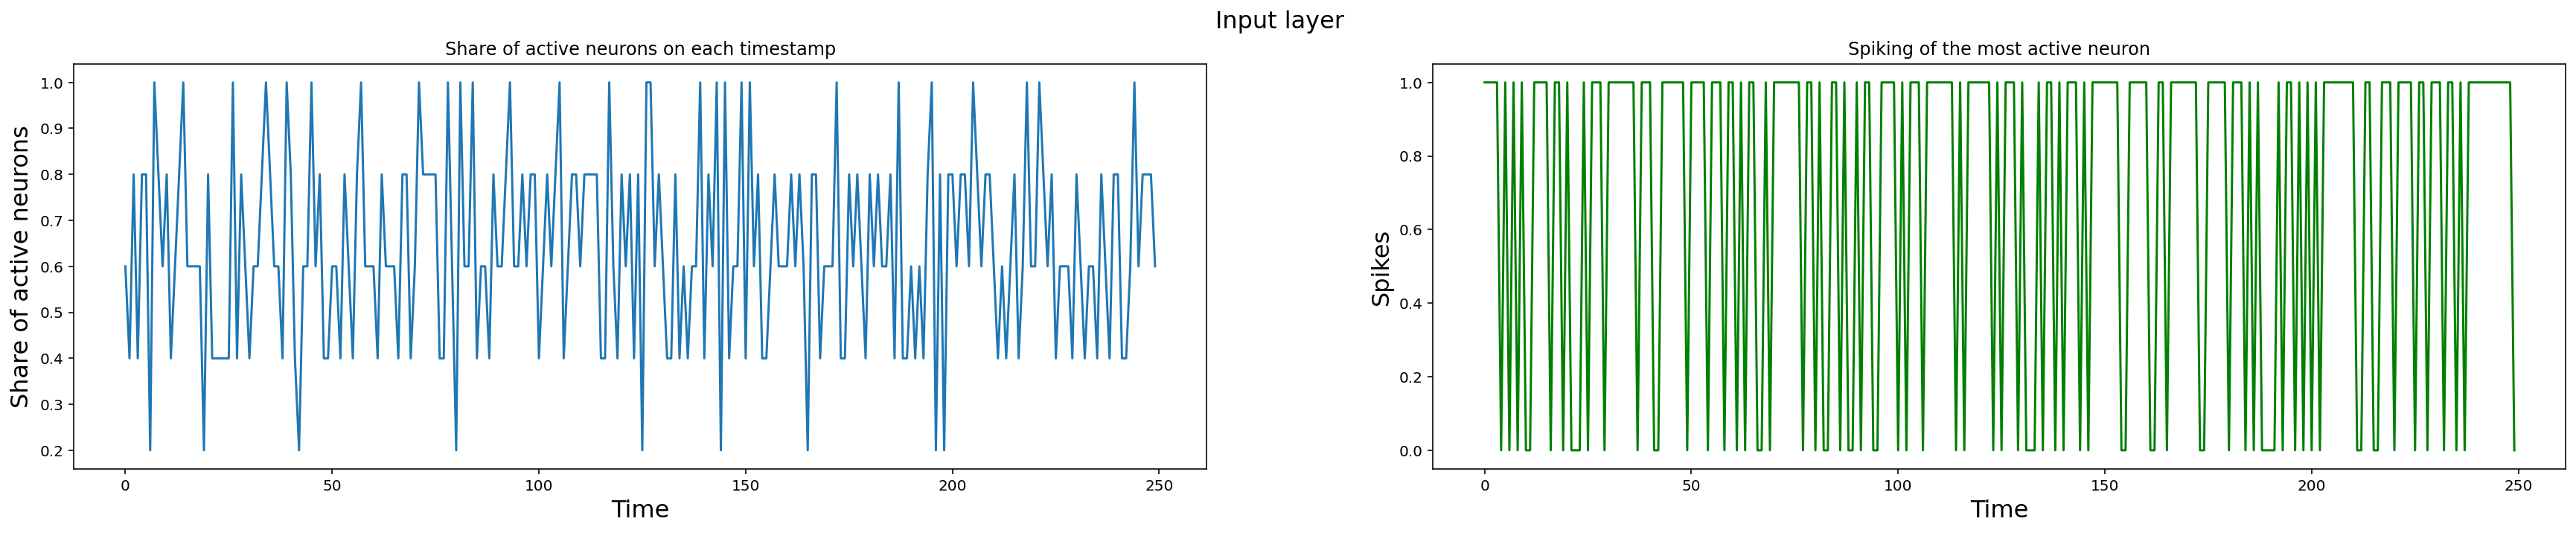

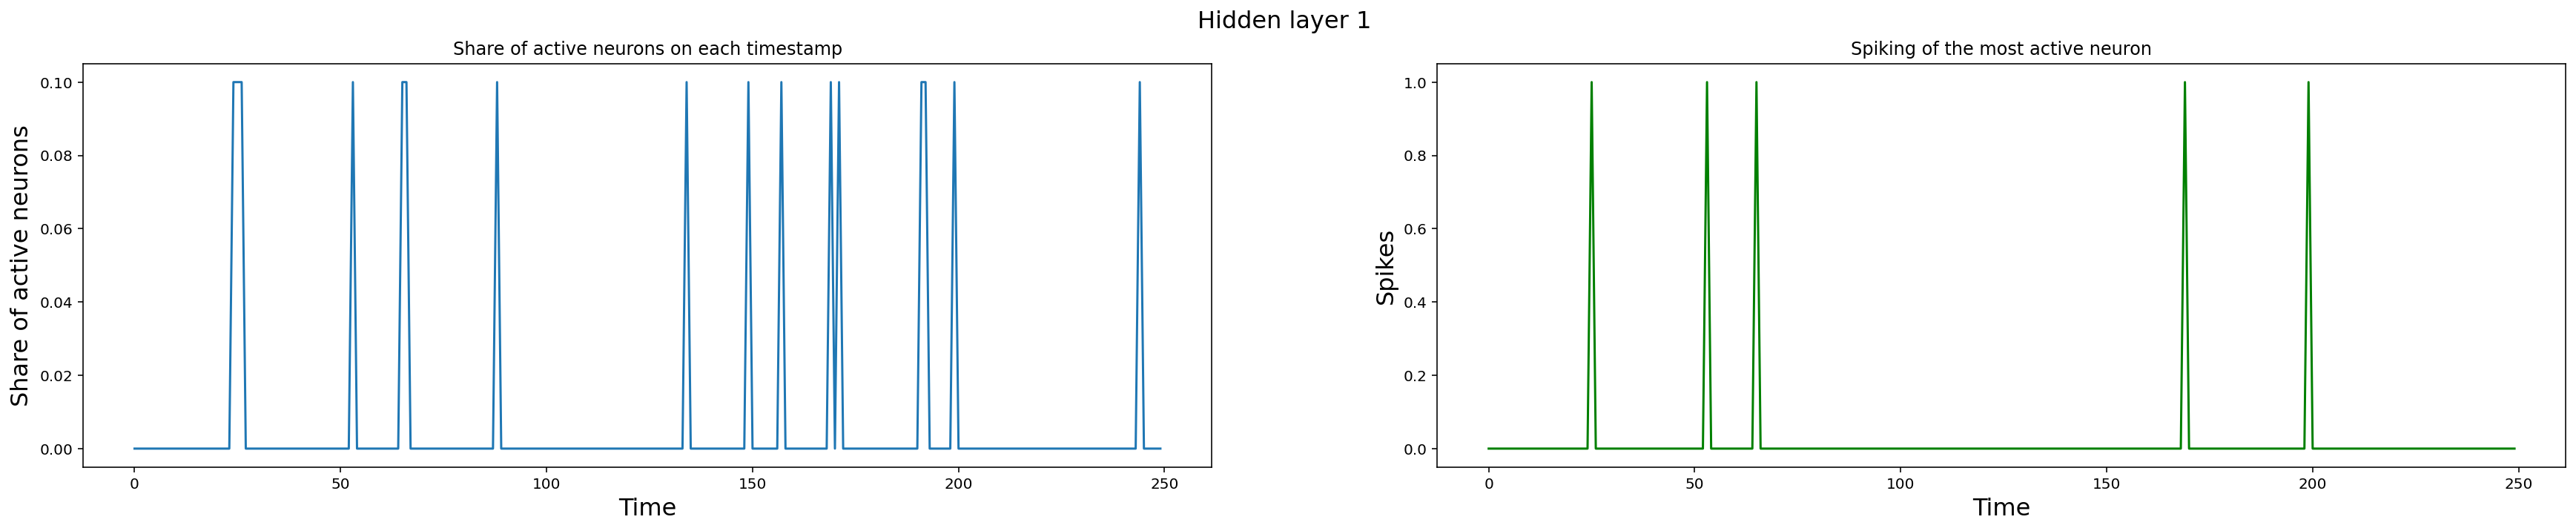

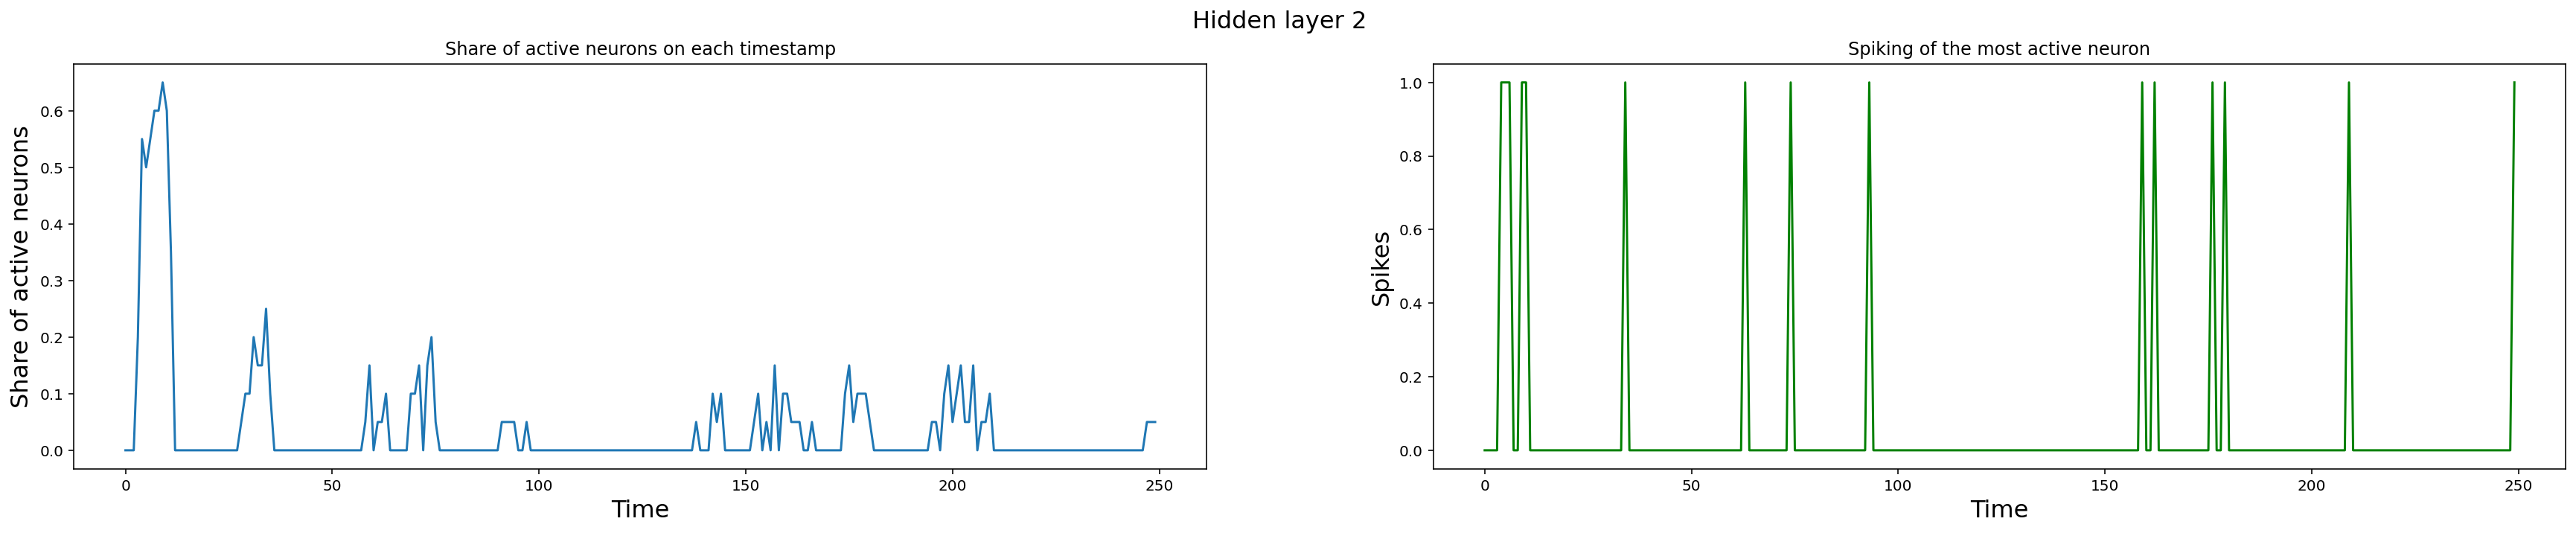

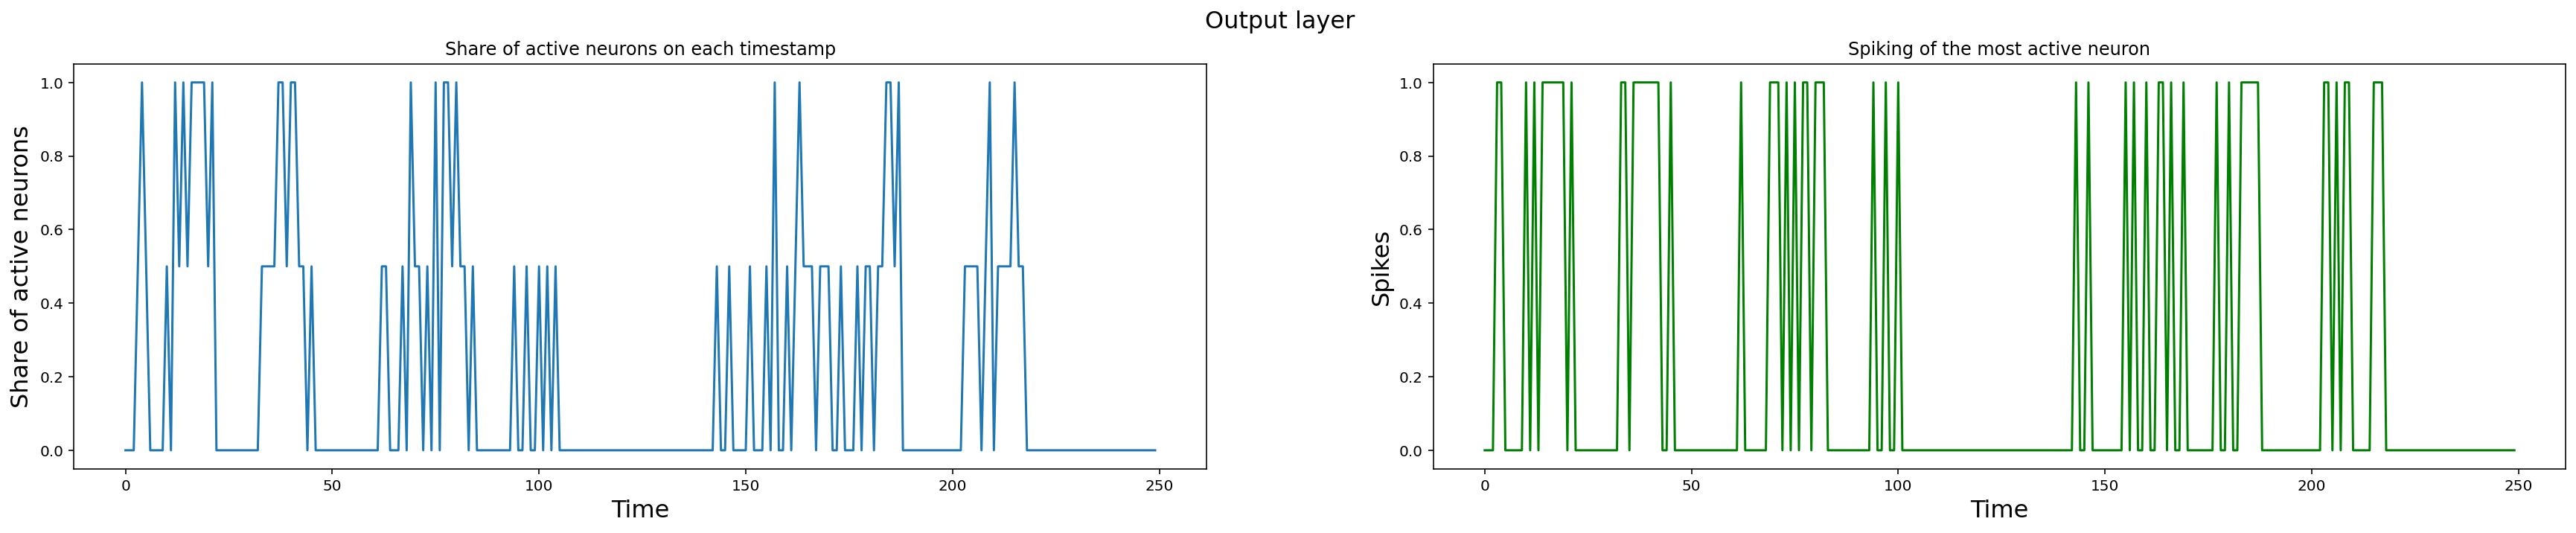

In [5]:
run_experiment()